In [ ]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import scipy.io as sio
from matplotlib import pyplot
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from keras.models import load_model
from tensorflow.keras import models
from tensorflow import keras
import pandas as pd

from keras.callbacks import EarlyStopping, ModelCheckpoint
from IPython import display

MODELS_DIR = 'models/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
MODEL_TF = MODELS_DIR + 'model'
MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'model_no_quant.tflite'
MODEL_TFLITE = MODELS_DIR + 'model.tflite'
MODEL_TFLITE_MICRO = MODELS_DIR + 'model.cpp'


In [ ]:
def predict_tflite(tflite_model, x_test):
  # Prepare the test data
  x_test_ = x_test.copy()
  #x_test_ = x_test_.reshape((x_test.size, 1))
  x_test_ = x_test_.astype(np.float32)

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  # If required, quantize the input layer (from float to integer)
  input_scale, input_zero_point = input_details["quantization"]
  if (input_scale, input_zero_point) != (0.0, 0):
    x_test_ = x_test_ / input_scale + input_zero_point
    x_test_ = x_test_.astype(input_details["dtype"])
  # Invoke the interpreter
  interpreter.set_tensor(input_details["index"], x_test_)
  interpreter.invoke()
  y_pred = interpreter.get_tensor(output_details["index"])[0]

  # If required, dequantized the output layer (from integer to float)
  output_scale, output_zero_point = output_details["quantization"]
  if (output_scale, output_zero_point) != (0.0, 0):
    y_pred = y_pred.astype(np.float32)
    y_pred = (y_pred - output_zero_point) * output_scale

  return y_pred


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Read training, validation and test data

In [ ]:
data_train=sio.loadmat('/content/drive/MyDrive/commands_train.mat') #Change this to point to your dataset
Input_train=data_train['Input_train']
Input_train=np.reshape(Input_train,[Input_train.shape[0],1,Input_train.shape[1],1])
Label_train=data_train['Label_train']

data_val=sio.loadmat('/content/drive/MyDrive/commands_val.mat') #Change this to point to your dataset
Input_val=data_val['Input_val']
Input_val=np.reshape(Input_val,[Input_val.shape[0],1,Input_val.shape[1],1])
Label_val=data_val['Label_val']


data_test=sio.loadmat('/content/drive/MyDrive/commands_test.mat') #Change this to point to your dataset
Input_test=data_test['Input_test']
Input_test=np.reshape(Input_test,[Input_test.shape[0],1,Input_test.shape[1],1])
Label_test=data_test['Label_test']

Label_train= tf.keras.utils.to_categorical(Label_train)
Label_val= tf.keras.utils.to_categorical(Label_val)


In [ ]:
Input_train.shape

(6000, 1, 16000, 1)

#Create a model

In [ ]:
model = tf.keras.Sequential()
model.add(layers.Conv2D(filters=1,kernel_size=[1,15],activation='relu', input_shape=(1,16000,1)))
model.add(layers.Conv2D(filters=1,kernel_size=[1,15],activation='relu'))
model.add(layers.MaxPooling2D(pool_size=[1,3]))
model.add(layers.Flatten())
model.add(layers.Dense(2,activation='softmax', input_shape=(16000,)))
#model.add(layers.Dropout(0.25))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1, 15986, 1)       16        
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 15972, 1)       16        
                                                                 
 max_pooling2d (MaxPooling2  (None, 1, 5324, 1)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 5324)              0         
                                                                 
 dense (Dense)               (None, 2)                 10650     
                                                                 
Total params: 10682 (41.73 KB)
Trainable params: 10682 (41.73 KB)
Non-trainable params: 0 (0.00 Byte)
____________________

Fit the model

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss=tf.keras.losses.CategoricalCrossentropy (), metrics=['accuracy'])

EPOCHS =1000
callbacks = [EarlyStopping(monitor='val_loss', patience=12), ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]# uses validation set to stop training when it start overfitting
history = model.fit(Input_train,Label_train,validation_data=(Input_val,Label_val),epochs=EPOCHS,callbacks=callbacks,batch_size=32, verbose=1, shuffle=True)


Epoch 1/1000
188/188 [==============================] - 5s 8ms/step - loss: 0.5566 - accuracy: 0.7445 - val_loss: 0.5069 - val_accuracy: 0.7711
Epoch 2/1000
 31/188 [===>..........................] - ETA: 0s - loss: 0.4068 - accuracy: 0.8427

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


188/188 [==============================] - 1s 5ms/step - loss: 0.4481 - accuracy: 0.8215 - val_loss: 0.4554 - val_accuracy: 0.8781
Epoch 3/1000
188/188 [==============================] - 1s 5ms/step - loss: 0.3891 - accuracy: 0.8497 - val_loss: 0.5848 - val_accuracy: 0.7736
Epoch 4/1000
188/188 [==============================] - 1s 5ms/step - loss: 0.3464 - accuracy: 0.8690 - val_loss: 0.5380 - val_accuracy: 0.7463
Epoch 5/1000
188/188 [==============================] - 1s 5ms/step - loss: 0.3057 - accuracy: 0.8832 - val_loss: 0.4188 - val_accuracy: 0.8806
Epoch 6/1000
188/188 [==============================] - 1s 5ms/step - loss: 0.2521 - accuracy: 0.9080 - val_loss: 0.4950 - val_accuracy: 0.8706
Epoch 7/1000
188/188 [==============================] - 1s 5ms/step - loss: 0.2237 - accuracy: 0.9185 - val_loss: 0.4558 - val_accuracy: 0.9005
Epoch 8/1000
188/188 [==============================] - 1s 5ms/step - loss: 0.2099 - accuracy: 0.9227 - val_loss: 0.4398 - val_accuracy: 0.8831
Epoch

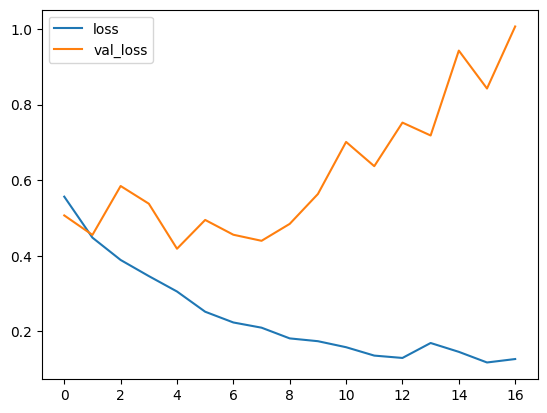

In [ ]:

model = load_model('./best_model.h5')
model.save('/content/drive/MyDrive/Dataset/Command_Words/best_model.h5')
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

Check test accuracy

In [ ]:
model=load_model('/content/drive/MyDrive/Dataset/Command_Words/best_model.h5')
model.save(MODEL_TF)
y_pred = np.reshape(np.argmax(model.predict(Input_test), axis=1),[len(Input_test),1])
y_true = Label_test

test_acc = float(sum(y_pred == y_true) / len(y_true))
print('Test accuracy is:')
print(f"{test_acc:.2%}")


13/13 [==============================] - 0s 6ms/step
Test accuracy is:
82.09%


<ipython-input-9-54796adbabe6>:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test_acc = float(sum(y_pred == y_true) / len(y_true))


In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_TF)
model_no_quant_tflite = converter.convert()

# Save the model to disk
open(MODEL_NO_QUANT_TFLITE, "wb").write(model_no_quant_tflite)
def representative_dataset():
  for i in range(500):
    yield([Input_train[i,:,:,:].reshape(1,1,16000,1).astype(np.float32)])

# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Enforce integer only quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
# Provide a representative dataset to ensure we quantize correctly.
converter.representative_dataset = representative_dataset
model_tflite = converter.convert()

# Save the model to disk
open(MODEL_TFLITE, "wb").write(model_tflite)



13976

In [ ]:
# Calculate predictions with full software
y_pred = np.reshape(np.argmax(model.predict(Input_test), axis=1),[len(Input_test),1])
y_true = Label_test

test_acc = float(sum(y_pred == y_true) / len(y_true))
print('Test accuracy with model:')
print(f"{test_acc:.2%}")
y_test_pred_no_quant_tflite=np.empty([Input_test.shape[0],1])
y_test_pred_tflite=np.empty([Input_test.shape[0],1])
# Calculate predictions with tensorflow lite
for i in range(0,Input_test.shape[0]):
  y_test_pred_no_quant_tflite[i,0]=np.argmax(predict_tflite(model_no_quant_tflite, Input_test[i:i+1,:,:,:]))

test_acc = float(sum(y_test_pred_no_quant_tflite == y_true) / len(y_true))
print('Test accuracy with model tf lite:')
print(f"{test_acc:.2%}")


# Calculate predictions with tensorflow lite quantized model
for i in range(0,Input_test.shape[0]):
  y_test_pred_tflite[i,0]=np.argmax(predict_tflite(model_tflite, Input_test[i:i+1,:,:,:]))
y_true = Label_test

test_acc = float(sum(y_test_pred_tflite == y_true) / len(y_true))
print('Test accuracy with model quantized:')
print(f"{test_acc:.2%}")





y_test_pred_tflite=np.empty([Input_test.shape[0],2])

# Calculate predictions with tensorflow lite quantized model
for i in range(0,Input_test.shape[0]):
  y_test_pred_tflite[i,:]=(predict_tflite(model_tflite, Input_test[i:i+1,:,:,:]))
y_true = Label_test

y_test_tflite = {"y_test_pred_tflite":y_test_pred_tflite}
sio.savemat('models/tflite_pred.mat',y_test_tflite)


13/13 [==============================] - 0s 3ms/step
Test accuracy with model:
82.09%


<ipython-input-11-ce0b79f3bb75>:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test_acc = float(sum(y_pred == y_true) / len(y_true))
<ipython-input-11-ce0b79f3bb75>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test_acc = float(sum(y_test_pred_no_quant_tflite == y_true) / len(y_true))


Test accuracy with model tf lite:
82.09%


<ipython-input-11-ce0b79f3bb75>:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test_acc = float(sum(y_test_pred_tflite == y_true) / len(y_true))


Test accuracy with model quantized:
83.33%


Note depending on the model the quantized version might have higher accuracy.

In [ ]:
# Calculate size
size_no_quant_tflite = os.path.getsize(MODEL_NO_QUANT_TFLITE)
size_tflite = os.path.getsize(MODEL_TFLITE)

# Compare size
# Compare size
pd.DataFrame.from_records(
    [["TensorFlow Lite", f"{size_no_quant_tflite} bytes ", f"(reduced by {0} bytes)"],
     ["TensorFlow Lite Quantized", f"{size_tflite} bytes", f"(reduced by {size_no_quant_tflite - size_tflite} bytes)"]],
     columns = ["Model", "Size", ""], index="Model")

Size                          
Model                                                            
TensorFlow Lite            45552 bytes       (reduced by 0 bytes)
TensorFlow Lite Quantized   13976 bytes  (reduced by 31576 bytes)

In [ ]:

# Install xxd if it is not available
!apt-get update && apt-get -qq install xxd
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}
# Update variable names
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:6 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,070 kB]
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [1,834 kB]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,463 kB]
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:13 http://security.ubuntu.com/ubuntu jamm